Visualizing Wavelet Noise Band-Limited Property...


/tmp/ipykernel_179068/2480331051.py:149: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.imshow(np.log1p(power_spectrum), cmap='hot')
/tmp/ipykernel_179068/2480331051.py:167: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.semilogy(freqs, radial_profile, linewidth=2)


ValueError: num must be an integer with 1 <= num <= 16, not 17

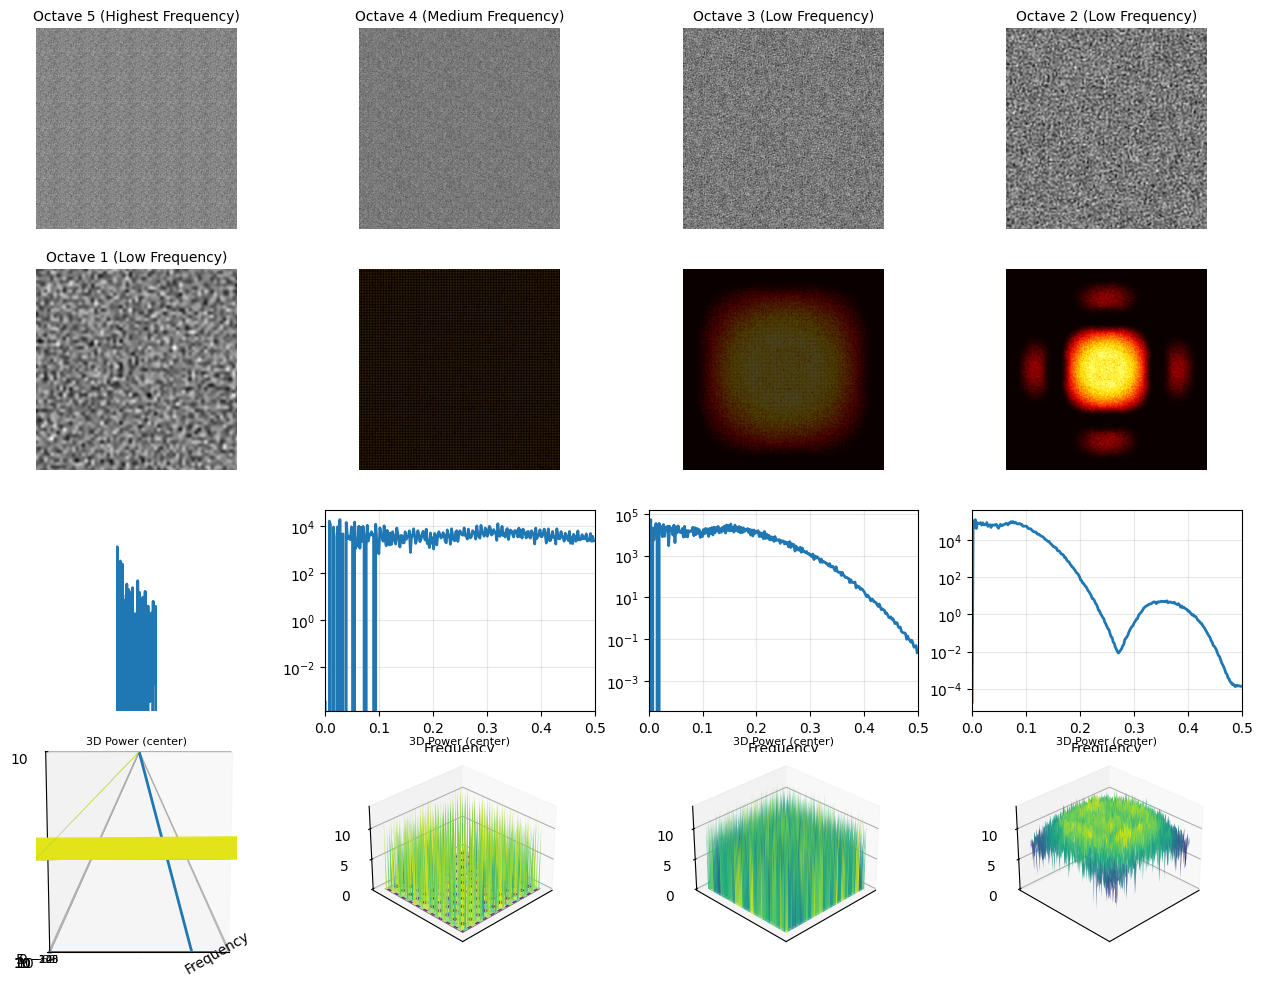

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import os

def analyze_single_band(filename, title):
    """Analyze a single band noise pattern to show band-limited property"""
    
    # Read the data
    try:
        with open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.float32)
        data = data.reshape((512, 512))
    except:
        print(f"Could not read {filename}")
        return None
    
    # Compute FFT
    data_centered = data - np.mean(data)
    F = fftshift(fft2(data_centered))
    magnitude = np.abs(F)
    power_spectrum = magnitude ** 2
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(title, fontsize=14, y=1.02)
    
    # 1. Noise pattern
    ax = axes[0]
    im = ax.imshow(data, cmap='gray')
    ax.set_title("Noise Pattern")
    ax.axis('off')
    
    # 2. FFT Magnitude (log scale)
    ax = axes[1]
    fft_log = np.log1p(magnitude)
    im = ax.imshow(fft_log, cmap='gray')
    ax.set_title("FFT Magnitude (log)")
    ax.axis('off')
    
    # 3. Power Spectrum
    ax = axes[2]
    power_log = np.log1p(power_spectrum)
    im = ax.imshow(power_log, cmap='gray')
    ax.set_title("Power Spectrum (log)")
    ax.axis('off')
    
    # 4. Power Spectrum with contours to show band
    ax = axes[3]
    # Create a cleaner visualization
    power_norm = power_spectrum / np.max(power_spectrum)
    im = ax.imshow(power_norm, cmap='hot', vmin=0, vmax=0.1)
    
    # Add contour lines to show the band
    h, w = power_norm.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    R = np.sqrt((X - cx)**2 + (Y - cy)**2)
    
    # Find the peak radius (where most energy is concentrated)
    radial_profile = []
    for r in range(min(cx, cy)):
        mask = (R >= r) & (R < r + 1)
        if np.any(mask):
            radial_profile.append(np.mean(power_spectrum[mask]))
        else:
            radial_profile.append(0)
    
    peak_radius = np.argmax(radial_profile)
    
    # Draw circles at key radii
    circle1 = plt.Circle((cx, cy), peak_radius * 0.7, fill=False, color='cyan', linewidth=2, linestyle='--')
    circle2 = plt.Circle((cx, cy), peak_radius, fill=False, color='yellow', linewidth=2)
    circle3 = plt.Circle((cx, cy), peak_radius * 1.3, fill=False, color='cyan', linewidth=2, linestyle='--')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    
    ax.set_title(f"Band Structure\n(peak at r≈{peak_radius})")
    ax.axis('off')
    
    # 5. Radial Power Spectrum
    ax = axes[4]
    radii = np.arange(len(radial_profile))
    normalized_freq = radii / (2 * len(radial_profile))  # Normalize to [0, 0.5]
    
    ax.semilogy(normalized_freq, radial_profile, 'b-', linewidth=2)
    ax.axvline(normalized_freq[peak_radius], color='r', linestyle='--', 
               label=f'Peak at f≈{normalized_freq[peak_radius]:.3f}')
    ax.set_xlabel('Normalized Frequency')
    ax.set_ylabel('Power')
    ax.set_title('Radial Power Spectrum')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlim(0, 0.5)
    
    plt.tight_layout()
    return fig, peak_radius

def compare_all_bands():
    """Create a comprehensive comparison of all bands"""
    
    # Define the files to analyze - try both naming schemes
    bands = []
    
    # Check for octave files first (preferred)
    if os.path.exists("wavelet_noise_octave_0.raw"):
        bands = [
            ("wavelet_noise_octave_5.raw", "Octave 5 (Highest Frequency)"),
            ("wavelet_noise_octave_4.raw", "Octave 4 (Medium Frequency)"),
            ("wavelet_noise_octave_3.raw", "Octave 3 (Low Frequency)"),
            ("wavelet_noise_octave_2.raw", "Octave 2 (Low Frequency)"),
            ("wavelet_noise_octave_1.raw", "Octave 1 (Low Frequency)"),
            ("wavelet_noise_octave_0.raw", "Octave 0 (Low Frequency)"),
            ("wavelet_noise_multiband_3.raw", "3-Band Combination")
        ]
    
    # Create figure for side-by-side comparison
    fig_comp = plt.figure(figsize=(16, 12))
    
    for idx, (filename, title) in enumerate(bands):
        if not os.path.exists(filename):
            print(f"File {filename} not found")
            continue
            
        # Read data
        with open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.float32).reshape((512, 512))
        
        # Compute FFT
        F = fftshift(fft2(data - np.mean(data)))
        power_spectrum = np.abs(F) ** 2
        
        # Row 1: Noise patterns
        ax = plt.subplot(4, 4, idx + 1)
        ax.imshow(data, cmap='gray')
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        
        # Row 2: Power spectra
        ax = plt.subplot(4, 4, idx + 5)
        ax.imshow(np.log1p(power_spectrum), cmap='hot')
        ax.axis('off')
        
        # Row 3: Radial profiles
        ax = plt.subplot(4, 4, idx + 9)
        h, w = power_spectrum.shape
        cy, cx = h // 2, w // 2
        Y, X = np.ogrid[:h, :w]
        R = np.sqrt((X - cx)**2 + (Y - cy)**2)
        
        max_r = min(cx, cy)
        radial_profile = []
        for r in range(max_r):
            mask = (R >= r) & (R < r + 1)
            if np.any(mask):
                radial_profile.append(np.mean(power_spectrum[mask]))
        
        freqs = np.arange(len(radial_profile)) / (2 * len(radial_profile))
        ax.semilogy(freqs, radial_profile, linewidth=2)
        ax.set_xlim(0, 0.5)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.set_ylabel('Power')
        ax.set_xlabel('Frequency')
        
        # Row 4: 3D surface plot of power spectrum (central region)
        ax = plt.subplot(4, 4, idx + 13, projection='3d')
        
        # Take central region
        size = 64
        center_slice = power_spectrum[cy-size:cy+size, cx-size:cx+size]
        X_mesh, Y_mesh = np.meshgrid(range(2*size), range(2*size))
        
        # Take log for better visualization
        Z = np.log1p(center_slice)
        
        ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', alpha=0.8)
        ax.set_title('3D Power (center)', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.view_init(elev=30, azim=45)
    
    plt.suptitle('Wavelet Noise Band-Limited Property Demonstration', fontsize=16)
    plt.tight_layout()
    plt.savefig('wavelet_band_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analyze each band individually
    for filename, title in bands:
        if os.path.exists(filename):
            fig, peak_r = analyze_single_band(filename, title)
            if fig:
                plt.savefig(f'{filename.replace(".raw", "")}_analysis.png', 
                           dpi=150, bbox_inches='tight')
                plt.show()

if __name__ == "__main__":
    print("Visualizing Wavelet Noise Band-Limited Property...")
    print("=" * 60)
    
    compare_all_bands()
    
    print("\nThe band-limited property is demonstrated by:")
    print("1. Each band has energy concentrated in a ring/annulus in frequency domain")
    print("2. Different bands have peaks at different frequencies (octaves apart)")
    print("3. Very little energy outside the designed frequency band")
    print("4. The 3-band combination shows multiple rings")
    
    print("\nAnalysis complete!")